# Necessary Imports

In [183]:
# Import necessary packages

import numpy as np
import torch
from torch import nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import DataLoader, TensorDataset, random_split
from time import time

In [184]:
import os

# Download The Dataset & Define The Transforms

In [205]:
from torchvision import datasets,transforms


# Đường dẫn đến các file
train_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\train.csv\\train.csv'
test_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\test.csv\\test.csv'

# Gán dữ liệu và nhãn từ các file
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


#train dataset
train_labels = torch.tensor(train_data.iloc[:, 0].values)
train_images = torch.tensor(train_data.iloc[:, 1:].values).float() / 255.0  # Chuẩn hóa
train_images = train_images.reshape(-1, 1, 28, 28)  # Reshape để phù hợp với định dạng (Batch, Channels, Height, Width)


test_images = torch.tensor(test_data.values).float() / 255.0
test_images = test_images.reshape(-1, 1, 28, 28)


# Tạo TensorDataset với nhãn
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Tạo DataLoader cho tập huấn luyện và validation
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# In ra kích thước để kiểm tra
print("Train Size:", train_size)
print("Val Size:", val_size)
print("Test Size:", len(test_dataset))



Train Size: 33600
Val Size: 8400
Test Size: 28000


# Exploring The Data

In [186]:
# Lấy dữ liệu
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


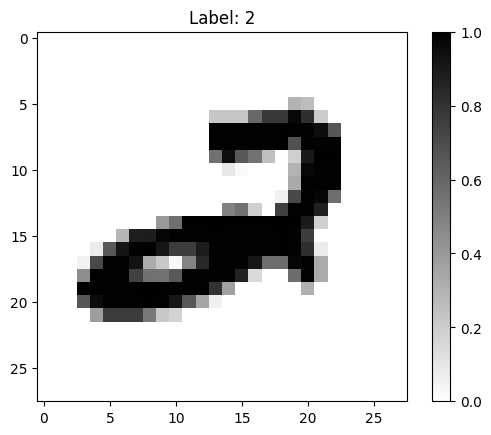

In [187]:
# Hiển thị ảnh đầu tiên và nhãn tương ứng

i = 5
image = images[5].numpy().squeeze()
label = labels[5].item()
plt.imshow(image, cmap='gray_r')
plt.title(f'Label: {label}')
plt.colorbar()
plt.show()

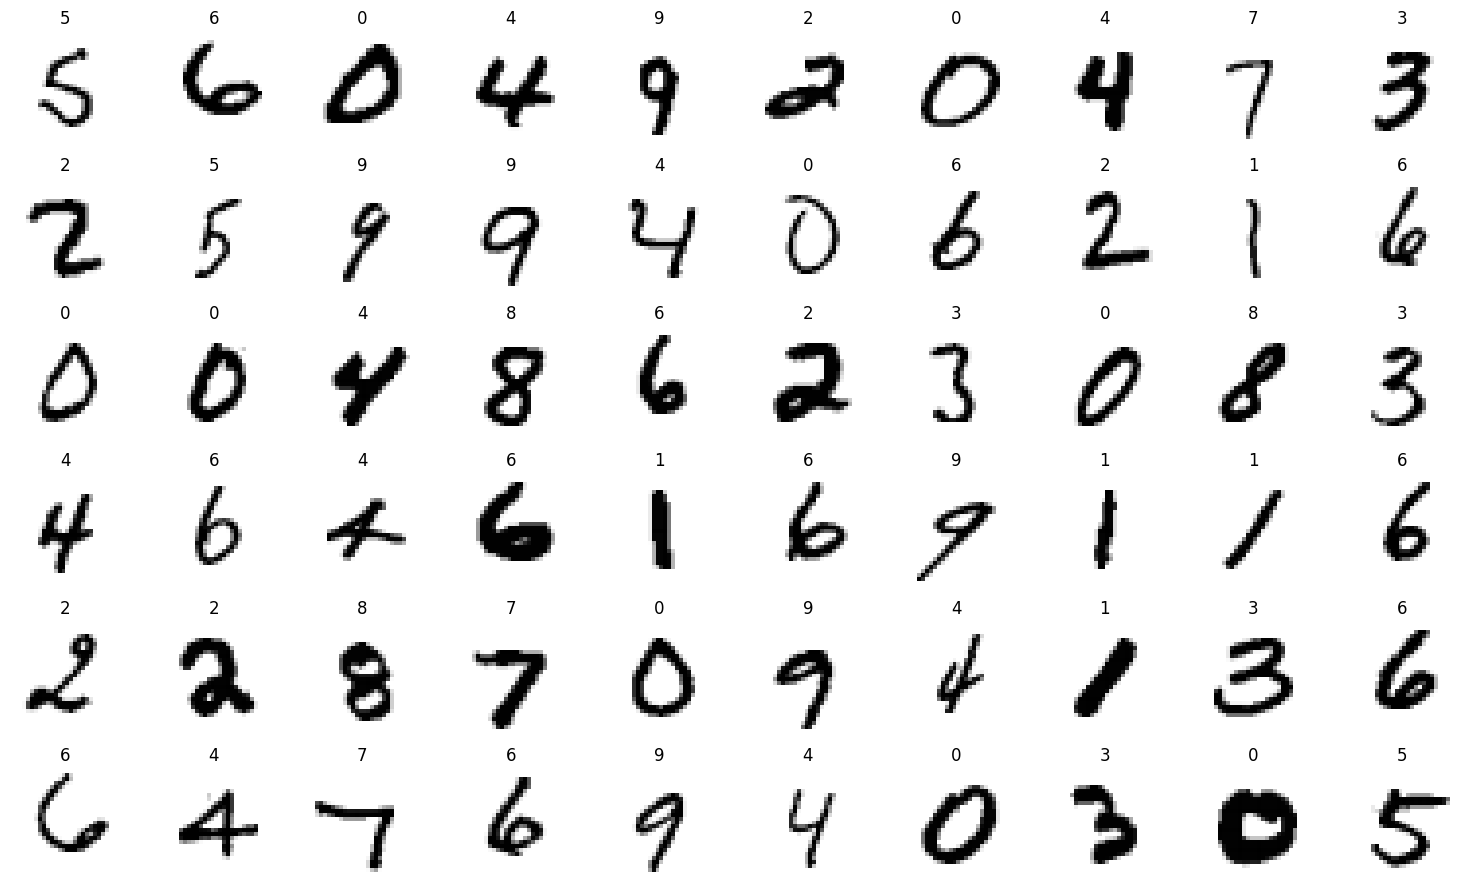

In [188]:
# Hiển thị lưới ảnh
figure, axes = plt.subplots(6, 10, figsize=(15, 9))  # Cấu hình subplot với kích thước phù hợp
axes = axes.flatten()  # Làm phẳng mảng axes để dễ vòng lặp
for idx, ax in enumerate(axes):
    if idx < len(images):  # Kiểm tra để tránh IndexError nếu số ảnh ít hơn 60
        image = images[idx].numpy().squeeze()
        ax.imshow(image, cmap='gray_r')
        ax.axis('off')
        ax.set_title(labels[idx].item())
plt.tight_layout()
plt.show()

# Defining The Neural Network

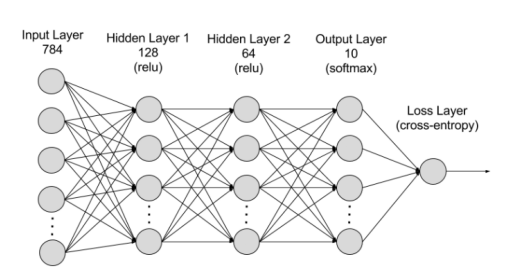

In [189]:
# Đường dẫn tới ảnh
image_path = 'C:\\Users\\ThanhTan\\Desktop\\nhandienchuviet\\DefiningTheNeuralNetwork.png'

# Đọc ảnh
img = mpimg.imread(image_path)

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')  # Tùy chọn không hiển thị trục
plt.show()

In [190]:
import torch.optim as optim

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)
)
# Xác định optimizer và criterion
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()



In [191]:
# Tạo một batch dữ liệu ngẫu nhiên và nhãn tương ứng
simple_input = torch.randn(64, 784, requires_grad=True)  # Giả sử batch_size là 64
simple_labels = torch.randint(0, output_size, (64,))  # Tạo nhãn ngẫu nhiên từ 0 đến 9


In [192]:
# Clear gradients (để đảm bảo gradients cũ không ảnh hưởng đến kết quả)
optimizer.zero_grad()

# Thực hiện forward pass
output = model(simple_input)

# Tính loss
loss = criterion(output, simple_labels)

# Backward pass để tính gradient
loss.backward()


In [193]:
# In ra gradient của trọng số trong lớp đầu tiên
print("Gradient of the first layer weights:\n", model[0].weight.grad)


Gradient of the first layer weights:
 tensor([[ 3.2376e-03, -2.6260e-03,  2.1340e-03,  ...,  3.7413e-03,
         -3.2568e-04, -4.0398e-04],
        [-5.4546e-04,  5.4134e-04,  3.2381e-03,  ..., -3.9058e-04,
          1.0614e-03, -3.3507e-03],
        [ 1.3123e-03,  1.0496e-03, -7.8731e-04,  ..., -7.9715e-04,
         -1.2434e-03, -3.9628e-03],
        ...,
        [ 5.0345e-04,  1.7974e-04,  6.4359e-04,  ...,  8.5771e-04,
          1.8507e-03,  4.5173e-05],
        [-1.3331e-03, -1.5084e-03, -3.0287e-03,  ..., -1.3280e-03,
         -1.6196e-03,  3.8081e-03],
        [-1.3496e-03, -2.2594e-03,  7.8343e-04,  ...,  2.4059e-03,
         -2.8879e-04,  1.7148e-03]])


# Training

In [194]:
num_epochs = 20  # Số lượng epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}')





Epoch 1/20, Train Loss: 2.139317971865336, Validation Loss: 1.7584995645465273, Train Accuracy: 0.4435119047619048, Validation Accuracy: 0.6273809523809524
Epoch 2/20, Train Loss: 1.137813202426547, Validation Loss: 0.7345707362348383, Train Accuracy: 0.7441071428571429, Validation Accuracy: 0.805952380952381
Epoch 3/20, Train Loss: 0.6047543770358677, Validation Loss: 0.49854927171360364, Train Accuracy: 0.8358630952380952, Validation Accuracy: 0.866904761904762
Epoch 4/20, Train Loss: 0.4578002295039949, Validation Loss: 0.41287472810257564, Train Accuracy: 0.8736309523809523, Validation Accuracy: 0.8858333333333334
Epoch 5/20, Train Loss: 0.39580922606445496, Validation Loss: 0.37015281346711243, Train Accuracy: 0.888125, Validation Accuracy: 0.8977380952380952
Epoch 6/20, Train Loss: 0.3609873952184405, Validation Loss: 0.34253827053489105, Train Accuracy: 0.8972321428571428, Validation Accuracy: 0.9045238095238095
Epoch 7/20, Train Loss: 0.33733042041460676, Validation Loss: 0.324

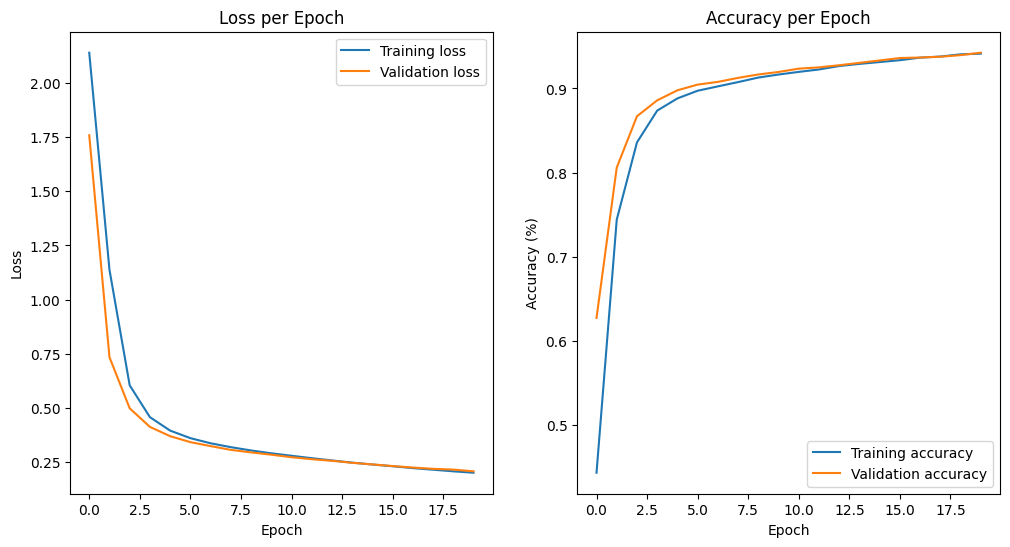

In [195]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ mất mát
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ biểu đồ độ chính xác
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


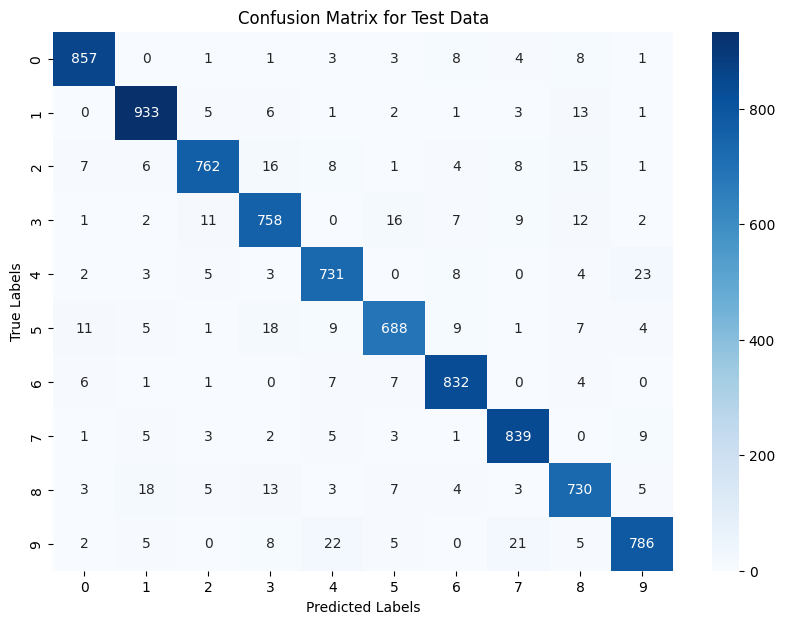

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       886
           1       0.95      0.97      0.96       965
           2       0.96      0.92      0.94       828
           3       0.92      0.93      0.92       818
           4       0.93      0.94      0.93       779
           5       0.94      0.91      0.93       753
           6       0.95      0.97      0.96       858
           7       0.94      0.97      0.96       868
           8       0.91      0.92      0.92       791
           9       0.94      0.92      0.93       854

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [197]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



# Tính toán confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()

# In báo cáo đánh giá chi tiết cho tập test
print(classification_report(all_labels, all_preds))



Predicted Digit = 9


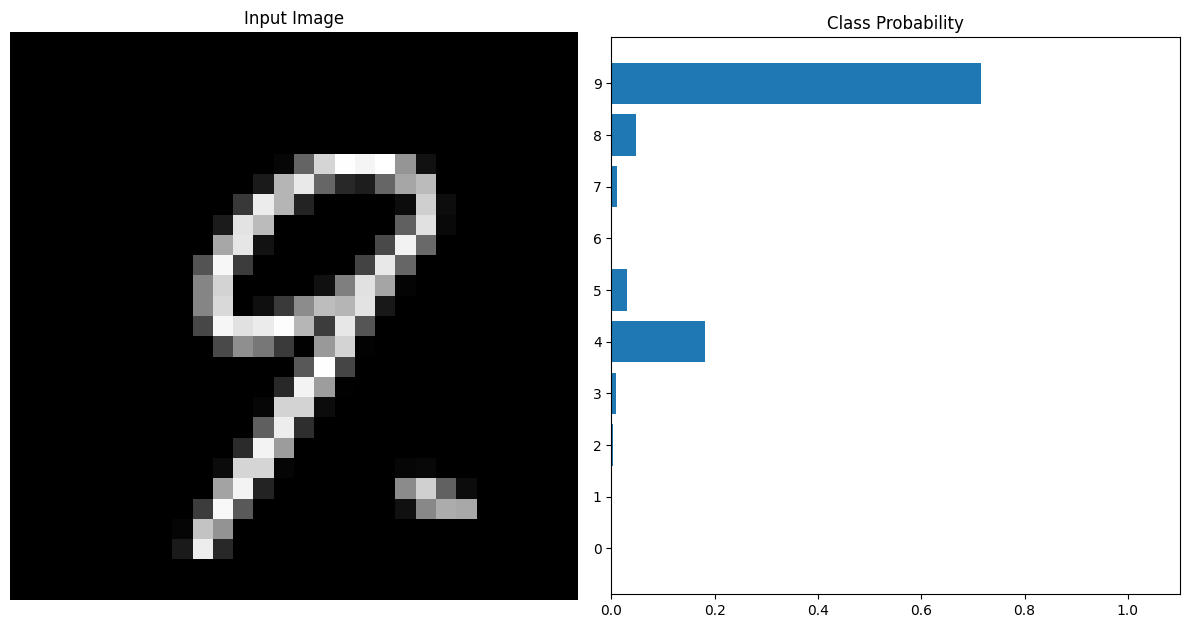

In [200]:
# Lấy một batch ảnh từ test_loader
batch = next(iter(test_loader))
images = batch[0]  # Lấy các ảnh từ batch

# Lấy một ảnh bất kỳ từ batch, ví dụ ảnh thứ 1
img = images[2].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

# Hiển thị ảnh và dự đoán
def view_classify(img, ps):
    ''' Function for viewing an image and its predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
    ax1.imshow(img.view(28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax1.set_title('Input Image')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

view_classify(img.view(1, 28, 28), ps)